# Fig2g - ROI-based-Fluorescence Analysis – FRAP Dual-Channel Processing

## Overview
This notebook processes time-lapse fluorescence microscopy data for **FRAP-like experiments** with two imaging channels:

- **Membrane channel** (`membrane`): captures membrane fluorescence signal.
- **mBaojin channel** (`mbaojin`): captures cytoskeleton or related signal.

The workflow:
1. Load paired membrane/mBaojin images and corresponding ROI annotations (Labelme JSON).
2. Create binary ROI masks from polygon annotations.
3. Apply masks to isolate the region of interest (ROI).
4. Align and rotate images for consistent orientation.
5. Split ROI into **unbleached** and **bleached** areas based on a horizontal division line.
6. Compute raw and normalized fluorescence intensities for both channels.
7. Generate:
   - **Time series plots** of normalized intensities.
   - **Side-by-side visualizations** of raw vs. processed frames.
   - **CSV** file containing numerical results.
   - **SVG** file of publication-ready plots.

---

## Input Requirements

### 1. Image Data
- Two folders:
  - `membrane_folder`: grayscale membrane-channel images.
  - `mbaojin_folder`: grayscale mBaojin-channel images.
- **File naming**: both folders must contain corresponding frames with matching identifiers (e.g., `frame01.tif` in both).
- Images should be the same size for correct alignment.

### 2. ROI Annotations
- Each frame must have a **Labelme JSON file** containing at least one polygon.
- The polygon defines the analysis ROI (only pixels inside ROI are included in intensity calculations).
- JSON files should follow the standard Labelme schema.

### 3. File Mapping
The script automatically pairs: mem_img_path, json_path, mbaojin_img_path

based on filename patterns.

---

## Parameters

| Parameter         | Type   | Description |
|-------------------|--------|-------------|
| `rotation_angle`  | float  | Rotation applied (degrees, positive = counterclockwise). |
| `line_height`     | int    | Horizontal split line (pixels from top). If `None`, defaults to image center. |
| `frame_interval`  | float  | Minutes between consecutive frames (default: 3.0). |
| `t0_frame`        | int    | 1-based index of the first post-bleach frame (default: 2). |

---

## Outputs
1. **CSV file** – fluorescence intensities per frame:
   - Raw values and normalized percentages for both channels and both regions.
2. **SVG file** – time series plot of normalized intensities.
3. **Interactive plots** – displayed within the notebook.
4. **Processed frame previews** – original vs. aligned/rotated images with ROI and split line.

---

## How to Run

1. Set folder paths:
   ```python
   membrane_folder = "/path/to/membrane_images"
   mbaojin_folder = "/path/to/mbaojin_images"

2.	Configure analysis parameters:
    rotation_angle = 0       # no rotation
    line_height = None       # auto center

3.	Run all cells in order:
    Load and map files.
    Process all images.
    Plot time series.
    Visualize processed frames.
    Save results.

4.	Check output files in the specified directory.

## 1. Import Required Libraries

In [1]:
import numpy as np
import json
import os
from pathlib import Path
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import pandas as pd
from typing import List, Tuple, Dict
import cv2

# Set matplotlib parameters
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.format'] = 'svg'

## 2. Set Folder Paths

**Please modify the paths below to your actual folder paths:**

In [2]:
# Please modify these paths to your actual folder paths
membrane_folder = "/Users/jyzerresico/chenlab/Synthetic Division/Fig2g/Fig2f/647"      # Membrane folder containing .tif and .json files
mbaojin_folder = "/Users/jyzerresico/chenlab/Synthetic Division/Fig2g/Fig2f/GFP"        # mBaojin folder containing only .tif files

# Verify folder existence
if not os.path.exists(membrane_folder):
    print(f"Membrane folder does not exist: {membrane_folder}")
    print("Please modify the path above")
elif not os.path.exists(mbaojin_folder):
    print(f"mBaojin folder does not exist: {mbaojin_folder}")
    print("Please modify the path above")
else:
    print("Folder paths set correctly")
    print(f"Membrane folder: {membrane_folder}")
    print(f"mBaojin folder: {mbaojin_folder}")

Folder paths set correctly
Membrane folder: /Users/jyzerresico/chenlab/Synthetic Division/Fig2g/Fig2f/647
mBaojin folder: /Users/jyzerresico/chenlab/Synthetic Division/Fig2g/Fig2f/GFP


## 3. Set Processing Parameters

In [3]:
# Set processing parameters
rotation_angle = 3      # Rotation angle (degrees)
line_height = 212      # Division line height (pixels), None means use half of image height

print(f"Rotation angle: {rotation_angle}°")
if line_height is None:
    print("Division line height: Automatic (half of image height)")
else:
    print(f"Division line height: {line_height} pixels")

Rotation angle: 3°
Division line height: 212 pixels


## 4. Define Fluorescence Analyzer Class

In [4]:
class FluorescenceAnalyzer:
    def __init__(self, membrane_folder: str, mbaojin_folder: str):
        
        self.membrane_folder = Path(membrane_folder)
        self.mbaojin_folder = Path(mbaojin_folder)
        self.mapping_pairs = []
        self.processed_images = []
        
    def load_and_map_files(self) -> List[Tuple[str, str, str]]:
        
        # Get images and JSON files from Membrane folder
        membrane_images = sorted(self.membrane_folder.glob("*.tif"))
        json_files = sorted(self.membrane_folder.glob("*.json"))
        
        # Get images from mBaojin folder
        mbaojin_images = sorted(self.mbaojin_folder.glob("*.tif"))
        
        # Verify quantity consistency
        if len(membrane_images) != len(json_files):
            raise ValueError("Image and JSON file counts don't match in Membrane folder")
        
        if len(membrane_images) != len(mbaojin_images):
            raise ValueError("Image counts don't match between folders")
        
        # Establish mapping relationships
        mapping_pairs = []
        for i in range(len(membrane_images)):
            membrane_img = membrane_images[i]
            json_file = json_files[i]
            mbaojin_img = mbaojin_images[i]
            
            mapping_pairs.append((str(membrane_img), str(json_file), str(mbaojin_img)))
        
        # Print mapping relationships confirmation (simplified format)
        for i, (mem_img, json_f, mbj_img) in enumerate(mapping_pairs):
            print(f"Frame {i+1}: {Path(mem_img).name} <-> {Path(json_f).name} <-> {Path(mbj_img).name}")
        
        self.mapping_pairs = mapping_pairs
        self._verify_image_dimensions()
        
        return mapping_pairs
    
    def _verify_image_dimensions(self):
        """Verify all images have consistent dimensions"""
        if not self.mapping_pairs:
            return
        
        # Check dimensions of first images
        first_mem_img = Image.open(self.mapping_pairs[0][0])
        first_mbj_img = Image.open(self.mapping_pairs[0][2])
        reference_size = first_mem_img.size
        
        all_consistent = True
        for i, (mem_img_path, _, mbj_img_path) in enumerate(self.mapping_pairs):
            mem_img = Image.open(mem_img_path)
            mbj_img = Image.open(mbj_img_path)
            
            if mem_img.size != reference_size or mbj_img.size != reference_size:
                all_consistent = False
        
        if not all_consistent:
            raise ValueError("Image dimensions are not consistent")
    
    def parse_labelme_json(self, json_path: str) -> List[Tuple[int, int]]:
       
        with open(json_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        if len(data['shapes']) != 1:
            raise ValueError(f"JSON file {json_path} does not contain exactly 1 annotation: {len(data['shapes'])}")
        
        shape = data['shapes'][0]
        if shape['shape_type'] != 'polygon':
            raise ValueError(f"Annotation type is not polygon: {shape['shape_type']}")
        
        # Convert coordinates to integers
        points = [(int(x), int(y)) for x, y in shape['points']]
        return points
    
    def create_mask_from_polygon(self, image_size: Tuple[int, int], polygon_points: List[Tuple[int, int]]) -> np.ndarray:
        
        mask = Image.new('L', image_size, 0)
        draw = ImageDraw.Draw(mask)
        draw.polygon(polygon_points, fill=255)
        return np.array(mask)
    
    def apply_mask_to_image(self, image: Image.Image, mask: np.ndarray) -> Image.Image:
        
        img_array = np.array(image.convert('L'))
        masked_array = img_array * (mask / 255.0)
        return Image.fromarray(masked_array.astype(np.uint8))
    
    def calculate_centroid(self, mask: np.ndarray) -> Tuple[float, float]:
        
        # Find coordinates of non-zero pixels in mask
        y_coords, x_coords = np.where(mask > 0)
        
        if len(x_coords) == 0:
            raise ValueError("No non-zero pixels in mask")
        
        # Calculate centroid
        centroid_x = np.mean(x_coords)
        centroid_y = np.mean(y_coords)
        
        return centroid_x, centroid_y
    
    def center_image_by_centroid(self, image: Image.Image, mask: np.ndarray) -> Tuple[Image.Image, np.ndarray]:
        
        # Calculate centroid
        centroid_x, centroid_y = self.calculate_centroid(mask)
        
        # Calculate image center
        img_center_x = image.width // 2
        img_center_y = image.height // 2
        
        # Calculate offset
        offset_x = int(img_center_x - centroid_x)
        offset_y = int(img_center_y - centroid_y)
        
        # Create new centered image
        centered_image = Image.new('L', image.size, 0)
        centered_mask = np.zeros_like(mask)
        
        # Apply offset
        img_array = np.array(image)
        
        # Calculate valid copy region
        src_x_start = max(0, -offset_x)
        src_x_end = min(image.width, image.width - offset_x)
        src_y_start = max(0, -offset_y)
        src_y_end = min(image.height, image.height - offset_y)
        
        dst_x_start = max(0, offset_x)
        dst_x_end = dst_x_start + (src_x_end - src_x_start)
        dst_y_start = max(0, offset_y)
        dst_y_end = dst_y_start + (src_y_end - src_y_start)
        
        # Copy image data
        centered_img_array = np.zeros_like(img_array)
        centered_img_array[dst_y_start:dst_y_end, dst_x_start:dst_x_end] = \
            img_array[src_y_start:src_y_end, src_x_start:src_x_end]
        
        # Copy mask data
        centered_mask[dst_y_start:dst_y_end, dst_x_start:dst_x_end] = \
            mask[src_y_start:src_y_end, src_x_start:src_x_end]
        
        centered_image = Image.fromarray(centered_img_array)
        
        return centered_image, centered_mask
    
    def rotate_image_and_mask(self, image: Image.Image, mask: np.ndarray, angle: float) -> Tuple[Image.Image, np.ndarray]:
       
        # Rotate image
        rotated_image = image.rotate(angle, fillcolor=0)
        
        # Rotate mask
        mask_image = Image.fromarray(mask.astype(np.uint8))
        rotated_mask_image = mask_image.rotate(angle, fillcolor=0)
        rotated_mask = np.array(rotated_mask_image)
        
        return rotated_image, rotated_mask
    
    def calculate_normalized_intensities(self, membrane_img: Image.Image, mbaojin_img: Image.Image, line_height: int) -> Dict:
        
        def process_single_image(image):
            img_array = np.array(image)
            height, width = img_array.shape
            
            # Ensure division line height is within valid range
            current_line_height = min(line_height, height - 1)
            
            # Split unbleached and bleached parts
            unbleached_part = img_array[:current_line_height, :]
            bleached_part = img_array[current_line_height:, :]
            
            # Calculate raw intensities
            unbleached_intensity = np.sum(unbleached_part)
            bleached_intensity = np.sum(bleached_part)
            total_intensity = unbleached_intensity + bleached_intensity
            
            # Calculate normalized intensities (percentages)
            if total_intensity == 0:
                unbleached_normalized = 0
                bleached_normalized = 0
            else:
                unbleached_normalized = (unbleached_intensity / total_intensity) * 100
                bleached_normalized = (bleached_intensity / total_intensity) * 100
            
            return {
                'unbleached_raw': unbleached_intensity,
                'bleached_raw': bleached_intensity,
                'total_raw': total_intensity,
                'unbleached_normalized': unbleached_normalized,
                'bleached_normalized': bleached_normalized
            }
        
        # Process both channels
        membrane_results = process_single_image(membrane_img)
        mbaojin_results = process_single_image(mbaojin_img)
        
        return {
            'membrane': membrane_results,
            'mbaojin': mbaojin_results,
            'line_height': min(line_height, membrane_img.height - 1)
        }
    
    def calculate_time_points_and_labels(self, frame_count: int) -> Tuple[List[float], List[str]]:
        
        actual_coords = []
        display_labels = []
        
        for i in range(frame_count):
            if i == 0:
                actual_coords.append(0.0)
                display_labels.append('')
            elif i == 1:
                actual_coords.append(1.0)
                display_labels.append('0')
            else:
                x_coord = 1.0 + 3.0 * (i - 1)
                display_time = 3.0 * (i - 1)
                
                actual_coords.append(x_coord)
                display_labels.append(str(int(display_time)))
        
        return actual_coords, display_labels
    
    def process_all_images(self, rotation_angle: float = 0, line_height: int = None) -> pd.DataFrame:
       
        if not self.mapping_pairs:
            raise ValueError("Please call load_and_map_files() first to establish mapping relationships")
        
        results = []
        processed_images = []
        
        # Calculate time point coordinates and labels
        actual_coords, display_labels = self.calculate_time_points_and_labels(len(self.mapping_pairs))
        
        for i, (mem_img_path, json_path, mbj_img_path) in enumerate(self.mapping_pairs):
            # Load images
            mem_img = Image.open(mem_img_path).convert('L')
            mbj_img = Image.open(mbj_img_path).convert('L')
            
            # Parse JSON annotation
            polygon_points = self.parse_labelme_json(json_path)
            
            # Create mask
            mask = self.create_mask_from_polygon(mbj_img.size, polygon_points)
            
            # Apply mask to both channel images
            masked_mem_img = self.apply_mask_to_image(mem_img, mask)
            masked_mbj_img = self.apply_mask_to_image(mbj_img, mask)
            
            # Center based on centroid (using mBaojin image centroid)
            centered_mem_img, centered_mask = self.center_image_by_centroid(masked_mem_img, mask)
            centered_mbj_img, _ = self.center_image_by_centroid(masked_mbj_img, mask)
            
            # Rotate images
            rotated_mem_img, rotated_mask = self.rotate_image_and_mask(centered_mem_img, centered_mask, rotation_angle)
            rotated_mbj_img, _ = self.rotate_image_and_mask(centered_mbj_img, centered_mask, rotation_angle)
            
            # Set division line height
            if line_height is None:
                current_line_height = rotated_mem_img.height // 2
            else:
                current_line_height = line_height
            
            # Calculate normalized intensities
            intensities = self.calculate_normalized_intensities(rotated_mem_img, rotated_mbj_img, current_line_height)
            
            # Save results
            result = {
                'frame_index': i + 1,
                'x_coordinate': actual_coords[i],
                'display_label': display_labels[i],
                'membrane_image': Path(mem_img_path).name,
                'json_file': Path(json_path).name,
                'mbaojin_image': Path(mbj_img_path).name,
                'membrane_unbleached_normalized': intensities['membrane']['unbleached_normalized'],
                'membrane_bleached_normalized': intensities['membrane']['bleached_normalized'],
                'mbaojin_unbleached_normalized': intensities['mbaojin']['unbleached_normalized'],
                'mbaojin_bleached_normalized': intensities['mbaojin']['bleached_normalized'],
                'membrane_unbleached_raw': intensities['membrane']['unbleached_raw'],
                'membrane_bleached_raw': intensities['membrane']['bleached_raw'],
                'mbaojin_unbleached_raw': intensities['mbaojin']['unbleached_raw'],
                'mbaojin_bleached_raw': intensities['mbaojin']['bleached_raw'],
                'rotation_angle': rotation_angle,
                'line_height': intensities['line_height']
            }
            results.append(result)
            
            # Save processed images for display
            processed_images.append({
                'frame_index': i + 1,
                'x_coordinate': actual_coords[i],
                'display_label': display_labels[i],
                'membrane_original': mem_img,
                'mbaojin_original': mbj_img,
                'membrane_final': rotated_mem_img,
                'mbaojin_final': rotated_mbj_img,
                'mask': rotated_mask,
                'line_height': intensities['line_height']
            })
        
        self.processed_images = processed_images
        
        # Convert to DataFrame
        df = pd.DataFrame(results)
        
        return df
    
    def plot_time_series(self, results_df: pd.DataFrame, save_svg: bool = True, output_filename: str = 'Fig2g.svg'):
        """
        Plot time series curves
        
        Args:
            results_df: Results DataFrame
            save_svg: Whether to save as SVG format
            output_filename: Output filename
        """
        fig, ax = plt.subplots(figsize=(6, 5))
        
        # Extract data
        x_coords = results_df['x_coordinate'].values
        
        # Plot four lines with proper zorder
        # Membrane - Purple
        ax.plot(x_coords, results_df['membrane_unbleached_normalized'], 
                color='purple', linestyle='-', linewidth=2, marker='o', markersize=6,
                label='Membrane Unbleached', alpha=0.8, zorder=3, clip_on=False)
        ax.plot(x_coords, results_df['membrane_bleached_normalized'], 
                color='purple', linestyle='--', linewidth=2, marker='o', markersize=6,
                label='Membrane Bleached', alpha=0.8, zorder=3, clip_on=False)
        
        # mBaojin - Green (changed marker from 's' to 'o' for circles)
        ax.plot(x_coords, results_df['mbaojin_unbleached_normalized'], 
                color='green', linestyle='-', linewidth=2, marker='o', markersize=6,
                label='mBaojin Unbleached', alpha=0.8, zorder=3, clip_on=False)
        ax.plot(x_coords, results_df['mbaojin_bleached_normalized'], 
                color='green', linestyle='--', linewidth=2, marker='o', markersize=6,
                label='mBaojin Bleached', alpha=0.8, zorder=3, clip_on=False)
        
        # Add vertical dashed line at x=1 (second frame position)
        ax.axvline(x=1, color='black', linestyle='--', linewidth=1.5, alpha=0.7, zorder=1)
        
        # Set y-axis
        ax.set_ylim(0, 100)
        ax.set_yticks([0, 20, 40, 60, 80, 100])
        ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])
        ax.set_ylabel('Relative intensity', fontsize=18)
        
        # Set x-axis - Keep x=0 at y-axis but use clip_on=False to show markers
        max_x = max(x_coords)
        ax.set_xlim(left=0)
        
        # Create comprehensive x-axis ticks including intermediate minutes
        all_x_ticks = []
        all_x_labels = []
        
        # Add all original data points first
        for i, (x_coord, label) in enumerate(zip(x_coords, results_df['display_label'])):
            all_x_ticks.append(x_coord)
            all_x_labels.append(label)
        
        # Add intermediate minute ticks between data points (without changing coordinate system)
        for i in range(1, len(x_coords)):
            if results_df['display_label'].iloc[i] and results_df['display_label'].iloc[i-1]:
                current_minute = int(results_df['display_label'].iloc[i])
                prev_minute = int(results_df['display_label'].iloc[i-1])
                current_x = x_coords[i]
                prev_x = x_coords[i-1]
                
                # Add intermediate minute ticks
                for min_val in range(prev_minute + 1, current_minute):
                    # Calculate x position for intermediate minute using linear interpolation
                    x_pos = prev_x + (current_x - prev_x) * (min_val - prev_minute) / (current_minute - prev_minute)
                    all_x_ticks.append(x_pos)
                    all_x_labels.append('')  # No label for intermediate ticks
        
        # Sort ticks and labels by x position
        tick_label_pairs = list(zip(all_x_ticks, all_x_labels))
        tick_label_pairs.sort(key=lambda x: x[0])
        sorted_ticks, sorted_labels = zip(*tick_label_pairs)
        
        # Set x-axis ticks and labels
        ax.set_xticks(sorted_ticks)
        ax.set_xticklabels(sorted_labels)
        ax.set_xlabel('Time (min)', fontsize=18)
        
        # Enhance tick appearance
        # Different lengths for labeled vs unlabeled ticks
        ax.tick_params(axis='x', which='major', length=4, width=1.5,  # Shorter for unlabeled ticks
                      labelsize=12, direction='out', pad=5)
        ax.tick_params(axis='y', which='major', length=6, width=2, 
                      labelsize=12, direction='out', pad=5)
        
        # Customize tick lengths - make numbered ticks longer
        for i, (tick_pos, label) in enumerate(zip(sorted_ticks, sorted_labels)):
            if label:  # If tick has a label (numbered ticks)
                ax.axvline(x=tick_pos, ymin=-0.02, ymax=0, color='black', 
                          linewidth=2, clip_on=False, zorder=2)
        
        # Remove grid, keep only xy axes
        ax.grid(False)
        
        # Set legend without frame and longer legend lines
        legend = ax.legend(fontsize=10, loc='upper right', frameon=False, 
                          handlelength=2.5)  # Increased from default ~1.0 to 2.5
        
        # Enhance and bold xy axes, remove top and right borders
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(2.5)
        ax.spines['bottom'].set_linewidth(2.5)
        ax.spines['left'].set_zorder(2)
        ax.spines['bottom'].set_zorder(2)
        
        plt.tight_layout()
        
        # Save as SVG format
        if save_svg:
            plt.savefig(output_filename, format='svg', dpi=300, bbox_inches='tight')
            print(f"Time series plot saved as: {output_filename}")
        
        plt.show()
        
        return fig, ax
    
    def visualize_results(self, max_frames: int = 4):
        """
        Visualize processing results
        
        Args:
            max_frames: Maximum number of frames to display
        """
        if not self.processed_images:
            print("Please call process_all_images() first to process images")
            return
        
        n_frames = min(len(self.processed_images), max_frames)
        
        fig, axes = plt.subplots(n_frames, 4, figsize=(16, 4 * n_frames))
        if n_frames == 1:
            axes = axes.reshape(1, -1)
        
        for i in range(n_frames):
            data = self.processed_images[i]
            
            display_info = data['display_label'] if data['display_label'] else '(y-axis)'
            
            # Membrane original image
            axes[i, 0].imshow(data['membrane_original'], cmap='gray')
            axes[i, 0].set_title(f'Frame {data["frame_index"]} \nMembrane Original')
            axes[i, 0].axis('off')
            
            # mBaojin original image
            axes[i, 1].imshow(data['mbaojin_original'], cmap='gray')
            axes[i, 1].set_title('mBaojin Original')
            axes[i, 1].axis('off')
            
            # Membrane final processed result
            axes[i, 2].imshow(data['membrane_final'], cmap='gray')
            axes[i, 2].axhline(y=data['line_height'], color='red', linewidth=2)
            axes[i, 2].set_title('Membrane Processed')
            axes[i, 2].axis('off')
            
            # mBaojin final processed result
            axes[i, 3].imshow(data['mbaojin_final'], cmap='gray')
            axes[i, 3].axhline(y=data['line_height'], color='red', linewidth=2)
            axes[i, 3].set_title('mBaojin Processed')
            axes[i, 3].axis('off')
        
        plt.tight_layout()
        plt.show()

## 5. Create Analyzer and Establish Mapping Relationships

In [5]:
# Create fluorescence analyzer
analyzer = FluorescenceAnalyzer(membrane_folder, mbaojin_folder)

# Load files and establish mapping relationships
try:
    mapping_pairs = analyzer.load_and_map_files()
    print(f"\nSuccessfully established mapping relationships for {len(mapping_pairs)} frames")
        
except Exception as e:
    print(f"Error establishing mapping relationships: {e}")

Frame 1: -1-647.tif <-> -1-647.json <-> -1-GFP.tif
Frame 2: 00-647.tif <-> 00-647.json <-> 00-GFP.tif
Frame 3: 03-647.tif <-> 03-647.json <-> 03-GFP.tif
Frame 4: 06-647.tif <-> 06-647.json <-> 06-GFP.tif
Frame 5: 09-647.tif <-> 09-647.json <-> 09-GFP.tif
Frame 6: 12-647.tif <-> 12-647.json <-> 12-GFP.tif
Frame 7: 15-647.tif <-> 15-647.json <-> 15-GFP.tif
Frame 8: 18-647.tif <-> 18-647.json <-> 18-GFP.tif

Successfully established mapping relationships for 8 frames


## 6. Process All Images

In [6]:
# Process all images
try:
    results_df = analyzer.process_all_images(
        rotation_angle=rotation_angle,
        line_height=line_height
    )
    
    print(f"\nProcessing complete! Processed {len(results_df)} frames")
    
except Exception as e:
    print(f"Error processing images: {e}")
    import traceback
    traceback.print_exc()


Processing complete! Processed 8 frames


## 7. Plot Time Series Curves

Time series plot saved as: Fig2g.svg


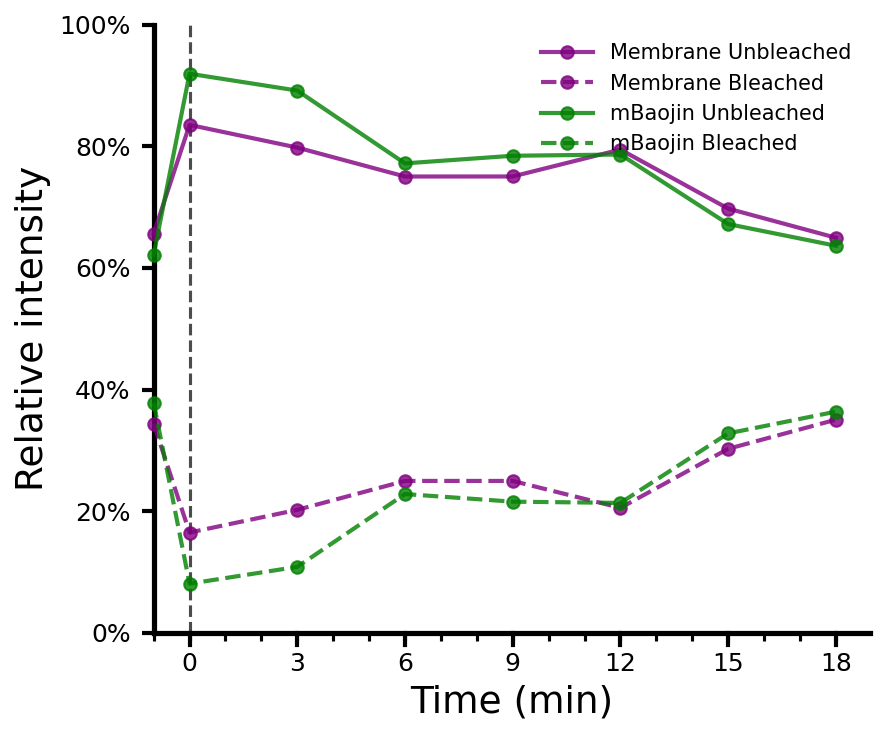

In [7]:
# Plot time series curves and save as SVG
if 'results_df' in locals():
    try:
        fig, ax = analyzer.plot_time_series(
            results_df, 
            save_svg=True, 
            output_filename='Fig2g.svg'
        )
        
    except Exception as e:
        print(f"Error plotting time series: {e}")
        import traceback
        traceback.print_exc()
else:
    print("No results to plot, please run image processing first")

## 8. Visualize Processing Results

In [8]:
# Visualize processing results for first 4 frames
#analyzer.visualize_results(max_frames=10)

## 9. Save Results

In [9]:
# Save results to CSV file
if 'results_df' in locals():
    output_filename = '/Users/jyzerresico/chenlab/Synthetic Division/Fig2g/Fig2g_fluorescence_analysis_results.csv'
    results_df.to_csv(output_filename, index=False, encoding='utf-8-sig')
    print(f"v5 version results saved to: {output_filename}")
    
    # Display saved file information
    file_size = os.path.getsize(output_filename)
    print(f"CSV file size: {file_size} bytes")
    print(f"Saved records: {len(results_df)}")
    
    # Check if SVG file exists
    svg_filename = '/Users/jyzerresico/chenlab/Synthetic Division/Fig2g/Fig2g.svg'
    if os.path.exists(svg_filename):
        svg_size = os.path.getsize(svg_filename)
        print(f"\nSVG chart saved: {svg_filename}")
        print(f"SVG file size: {svg_size} bytes")
    
else:
    print("No results to save")

v5 version results saved to: /Users/jyzerresico/chenlab/Synthetic Division/Fig2g/Fig2g_fluorescence_analysis_results.csv
CSV file size: 1481 bytes
Saved records: 8

SVG chart saved: /Users/jyzerresico/chenlab/Synthetic Division/Fig2g/Fig2g.svg
SVG file size: 41888 bytes
